In [89]:
# for classification of all files in the folder
# 19.02.2017 -- start

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from EEG_mat_reading import EEG_read, seizureStartEndInd, EEG_part, EEG_data_prep_1, RR_part, RR_data_prep_3
import sklearn
import timeit
from sklearn.metrics import precision_recall_fscore_support as score

In [90]:
# data_path = 'C:/temp'
#data_path = 'D:/Dropbox/EEG_ECG_DATA/MAT/temp'
#data_path = '/media/antp/DATA/Dropbox/EEG_ECG_DATA/MAT/temp'
#data_path = '/media/antp/DATA/Dropbox/EEG_ECG_DATA/MAT/Focal Seizures_processed'
data_path = '/media/antp/DATA/Dropbox/EEG_ECG_DATA/MAT/Generalized Seizures_processed'
#data_path = '/media/antp/DATA/Dropbox/EEG_ECG_DATA/MAT/temp'

s = os.listdir(data_path)  # list with names of the files in directory
#fn = 'volkogon-15.mat'
#fn = 'dukova-15.mat'
#fn = 'tarasov-18.mat'

# initial settings
TT_start = 60  # sec/samples, before seizure
TT_end = 0
P = 0.8  # ratio for training set
RR_type = "RR"
#time_windows = range(60, 180, )
time_windows = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600]  #[10, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300]
k = 0  # counter for the classification results for each particular time window
# iterating over all files in the folder, to collect the set of samples
cl_res = [] # empty list for classification results
#cl_res = np.empty_like(time_windows, dtype=float)  # classification results for each time window
true_res = []  # empty list for true results
pr=[]
rec=[]
fs=[]
sup=[]
M=[]


In [91]:
for TT_start in time_windows:  # for various window durations
    data = [] # empty list for the data
    targets = []  # empty list for the targets
    print(TT_start)
    flag = 'first'
    for filename in s:  # for all files
        if filename.endswith(".mat"):
            # reading the file with data
            print(filename)
            qwe, xxx = EEG_read(data_path, filename)
            # extration the data from all the files and all seizures
            targ = 1  # target mark for the data, closer to seizure
            (data1, target1) = RR_data_prep_3(qwe, TT_start, TT_end, RR_type, targ, 't')
            targ = 0  # target mark for the data, more far from the seizure
            (data2, target2) = RR_data_prep_3(qwe, 2 * TT_start, TT_start, RR_type, targ, 't')
            if data1.any() and data2.any():
                if flag == 'first':
                    data = np.vstack((data1, data2))
                    # targets = np.ravel(np.row_stack((target1, target2)))  # targets = np.ravel(targets)
                    targets = np.append(target1, target2)
                    flag = 'other'
                else:
                    #data.append(data1)
                    #data.append(data2)
                    data = np.vstack((data, data1))
                    data = np.vstack((data, data2))
                    # targets = np.ravel(np.row_stack((target1, target2)))
                    # targets = np.ravel(np.row_stack((targets, target1)))
                    targets = np.append(targets, target1)
                    targets = np.append(targets, target2)
                    #targets = np.ravel(np.row_stack((targets, target2)))

        else:
            continue
    
    # permutation of the items in the set
    perm = np.random.permutation(data.shape[0])  # preparing the numbers to shuffle
    Data = data[perm, :]  # permuted data
    Targets = targets[perm]  # permuted targets
    train = range(int(round(P * Data.shape[0])))  # numbers of elements in training set
    test = range(int(round(P * Data.shape[0])), data.shape[0])  # numbers of elements in test set

    #########
    # SVM calling and training:
    from sklearn import svm
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

    classifier = svm.SVC(kernel='rbf')  # (kernel='linear')# other kernels: (kernel='poly', degree=3), (kernel='rbf')

    ######
    #  fitting classifiers
    # print("All Targets = ", Targets[train])
    #start_time = timeit.default_timer()
    classifier.fit(Data[train], Targets[train])
    #elapsed = timeit.default_timer()
    #print("Classifier is fit.") #% (elapsed - start_time)

    # predicting the class in test set:
    cp= classifier.predict(Data[test, :])
    cl_res.append(cp)  # appending the current results of classification
    true_res.append(Targets[test])  # sroting the true labels
    print("Classification results: ", cp)
    print("Correct results: ", Targets[test])
    
    #smp_report = metrics.precision_recall_fscore_support(Targets[test], cp, average = 'micro')
    precision, recall, fscore, support = score(Targets[test], cp, average = 'micro')

    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))
    pr.append(precision)
    rec.append(recall)
    fs.append(fscore)
    sup.append(support)
    #sc = classifier.score(Data[test, :], Targets[test])
    #cl_res[k] = sc
        #print(TT_start, sc, cl_res)
    #cl_res = np.append(cl_res, sc)
    #print("Classifier score = ", cl_res)
    k+=1
   

30
levchenko2_21_06_14-14-15-16.mat
drozdov-14.mat
dukova-15.mat
feschenko-15.mat
karpenko-15.mat
kharchenko-15-16.mat
kostuk-15.mat
levchenko1_26_01_14-15.mat
marchenko-15.mat
marchenko1-15.mat
petrian-15.mat
semashko-14.mat
semashko1-14.mat
semashko2-14.mat
shamina-15.mat
surdu-15.mat
yakimets-14.mat
Classification results:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Correct results:  [0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
precision: 0.4444444444444444
recall: 0.4444444444444444
fscore: 0.4444444444444444
support: None
60
levchenko2_21_06_14-14-15-16.mat
drozdov-14.mat
dukova-15.mat
feschenko-15.mat
karpenko-15.mat
kharchenko-15-16.mat
kostuk-15.mat
levchenko1_26_01_14-15.mat
marchenko-15.mat
marchenko1-15.mat
petrian-15.mat
semashko-14.mat
semashko1-14.mat
semashko2-14.mat
shamina-15.mat
surdu-15.mat
yakimets-14.mat
Classification results:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Correct results:  [0 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1

In [92]:
print(pr)

[0.44444444444444442, 0.48148148148148145, 0.48148148148148145, 0.48148148148148145, 0.37037037037037035, 0.5, 0.53846153846153844, 0.5, 0.57692307692307687, 0.38461538461538464, 0.46153846153846156, 0.47999999999999998, 0.47999999999999998, 0.47999999999999998, 0.41666666666666669, 0.33333333333333331, 0.52173913043478259, 0.56521739130434778, 0.39130434782608697, 0.39130434782608697]


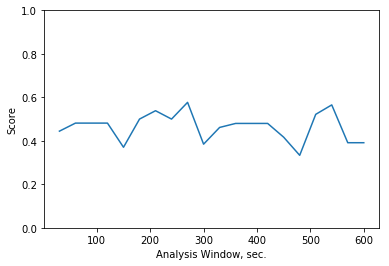

In [93]:
plt.plot(time_windows, fs)
plt.ylabel("Score")
plt.xlabel("Analysis Window, sec.")
plt.ylim((0,1))
plt.show()